In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

In [2]:
def remove_outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  
        sharex=True,  
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    ) 
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    ) 
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  

def labeled_barplot(data, feature, perc=False, n=None):
    total = len(data[feature])  
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  
        else:
            label = p.get_height() 

        x = p.get_x() + p.get_width() / 2  
        y = p.get_height()

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        ) 

    plt.show() 

def stacked_barplot(data, predictor, target):
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

def distribution_plot_wrt_target(data, predictor, target):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[2]))
    sns.histplot(
        data=data[data[target] == target_uniq[2]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

def checking_overfitting_undefitting(y_train, y_train_pred, y_test, y_test_pred):
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    if training_accuracy<=0.65:
        print("Model is underfitting.") 
    elif training_accuracy>0.65 and abs(training_accuracy-testing_accuracy)>0.15:
        print("Model is overfitting.")
    else:
        print("Model is not underfitting/overfitting.")

def calculate_classification_metrics(y_true, y_pred, algorithm):
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average='weighted'), 3)
    recall = round(recall_score(y_true, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_true, y_pred, average='weighted'), 3)
    print("Algorithm: ", algorithm)
    print()
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Overcast', 'Clear','Foggy']
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.90) and (logs.get('accuracy')>0.95):
            print("\nValidation and training accuracies are high so cancelling training!")
            self.model.stop_training = True


In [3]:
data = pd.read_csv("/Users/jaint/OneDrive/Desktop/weather-forecast/weather_forecast_dataset/weatherHistory.csv")
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [6]:
print(data["Summary"].value_counts())

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [7]:
data = data[(data["Summary"] == "Overcast") | (data["Summary"] == "Clear") | (data["Summary"] == "Foggy")]
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34635 entries, 46 to 96436
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            34635 non-null  object 
 1   Summary                   34635 non-null  object 
 2   Precip Type               34396 non-null  object 
 3   Temperature (C)           34635 non-null  float64
 4   Apparent Temperature (C)  34635 non-null  float64
 5   Humidity                  34635 non-null  float64
 6   Wind Speed (km/h)         34635 non-null  float64
 7   Wind Bearing (degrees)    34635 non-null  float64
 8   Visibility (km)           34635 non-null  float64
 9   Loud Cover                34635 non-null  float64
 10  Pressure (millibars)      34635 non-null  float64
 11  Daily Summary             34635 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.4+ MB


In [8]:
missing_values_count = data.isnull().sum()
missing_values_count

Formatted Date                0
Summary                       0
Precip Type                 239
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [9]:
data.dropna(inplace=True) 
missing_values_count = data.isnull().sum()
missing_values_count

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [10]:
print("Duplicated Values: ",data.duplicated().sum())

Duplicated Values:  17


In [11]:
data.drop_duplicates(inplace=True)
print("Duplicated Values: ", data.duplicated().sum())

Duplicated Values:  0


In [12]:
float_cols = data.select_dtypes(include='float')
data[float_cols.columns] = float_cols.round(2)
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
46,2006-04-10 22:00:00.000 +0200,Overcast,rain,14.42,14.42,0.58,20.01,159.0,15.83,0.0,1007.85,Mostly cloudy throughout the day.
47,2006-04-10 23:00:00.000 +0200,Overcast,rain,14.26,14.26,0.59,16.50,168.0,14.96,0.0,1007.89,Mostly cloudy throughout the day.
48,2006-04-11 00:00:00.000 +0200,Overcast,rain,13.77,13.77,0.60,17.10,160.0,15.83,0.0,1007.36,Foggy in the evening.
49,2006-04-11 01:00:00.000 +0200,Overcast,rain,13.28,13.28,0.63,14.36,160.0,15.83,0.0,1007.26,Foggy in the evening.
50,2006-04-11 02:00:00.000 +0200,Overcast,rain,8.63,5.47,0.87,22.04,32.0,6.70,0.0,1005.10,Foggy in the evening.


In [13]:
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], errors='coerce')
data["Time"] = [d.time() for d in data['Formatted Date']]
data["Time"] = data["Time"].astype(str)
data["Time"] = data["Time"].str.split(':').str[0].astype(int)
data["Date"] = [d.date() for d in data['Formatted Date']]
data["Date"]= data["Date"].astype(str)
data["Year"] = data["Date"].str.split('-').str[0].astype(int)
data["Month"] = data["Date"].str.split('-').str[1].astype(int)
data["Day"] = data["Date"].str.split('-').str[2].astype(int)
data = data.drop(columns=['Formatted Date','Date'], axis=1)

In [14]:
data["Loud Cover"].value_counts()

0.0    34379
Name: Loud Cover, dtype: int64

In [15]:
data.drop(columns=["Loud Cover"], axis=1, inplace=True)
data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Time,Year,Month,Day
46,Overcast,rain,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,Mostly cloudy throughout the day.,22,2006,4,10
47,Overcast,rain,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,Mostly cloudy throughout the day.,23,2006,4,10
48,Overcast,rain,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,Foggy in the evening.,0,2006,4,11
49,Overcast,rain,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,Foggy in the evening.,1,2006,4,11
50,Overcast,rain,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,Foggy in the evening.,2,2006,4,11


In [16]:
numeric_columns = list(data.select_dtypes(include=['float64', 'int64']).columns)
categorical_columns = list(data.select_dtypes(include=['object']).columns)
continuous_columns = [i for i in numeric_columns if len(list(data[i].unique()))>=25]
discrete_columns = [i for i in numeric_columns if len(list(data[i].unique()))<25]
print("Numerical Columns: ", numeric_columns)
print()
print("Categorical Columns: ", categorical_columns)
print()
print("Continuous Columns: ", continuous_columns)
print()
print("Discrete Columns: ", discrete_columns)

Numerical Columns:  ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

Categorical Columns:  ['Summary', 'Precip Type', 'Daily Summary']

Continuous Columns:  ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

Discrete Columns:  []


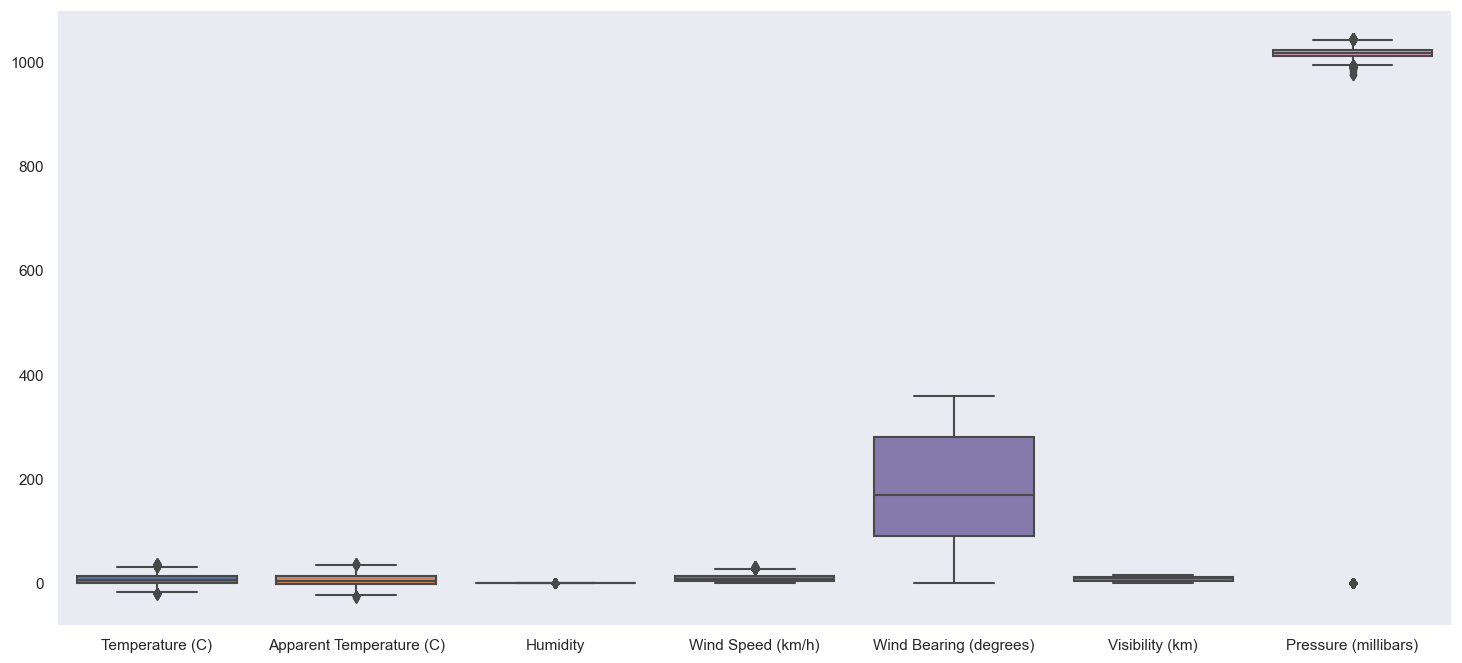

In [17]:
plt.figure(figsize=(18, 8)) 
sns.boxplot(data=data[numeric_columns])
plt.show()

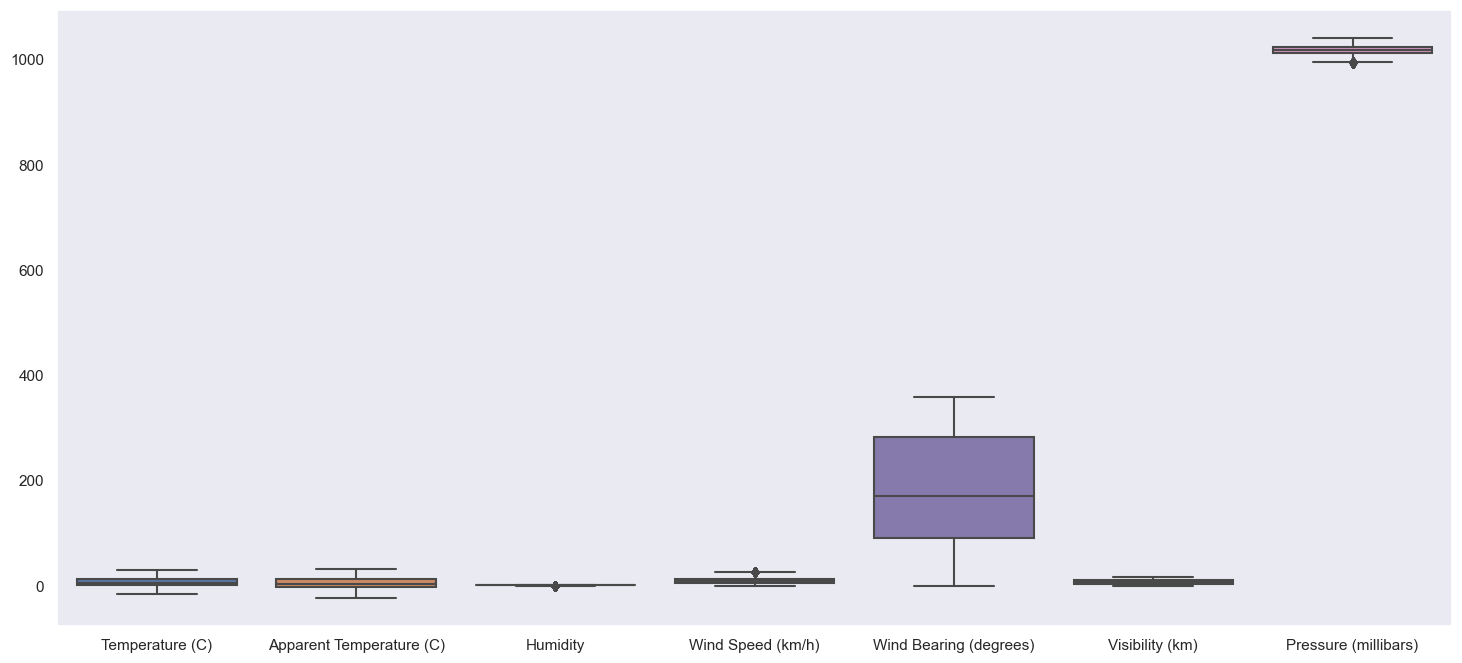

In [18]:
data = remove_outliers(data, "Pressure (millibars)")
data = remove_outliers(data, "Wind Speed (km/h)")
data = remove_outliers(data, "Humidity")
data = remove_outliers(data, "Temperature (C)")
data = remove_outliers(data, "Apparent Temperature (C)")

plt.figure(figsize=(18, 8)) 
sns.boxplot(data=data[numeric_columns])
plt.show()

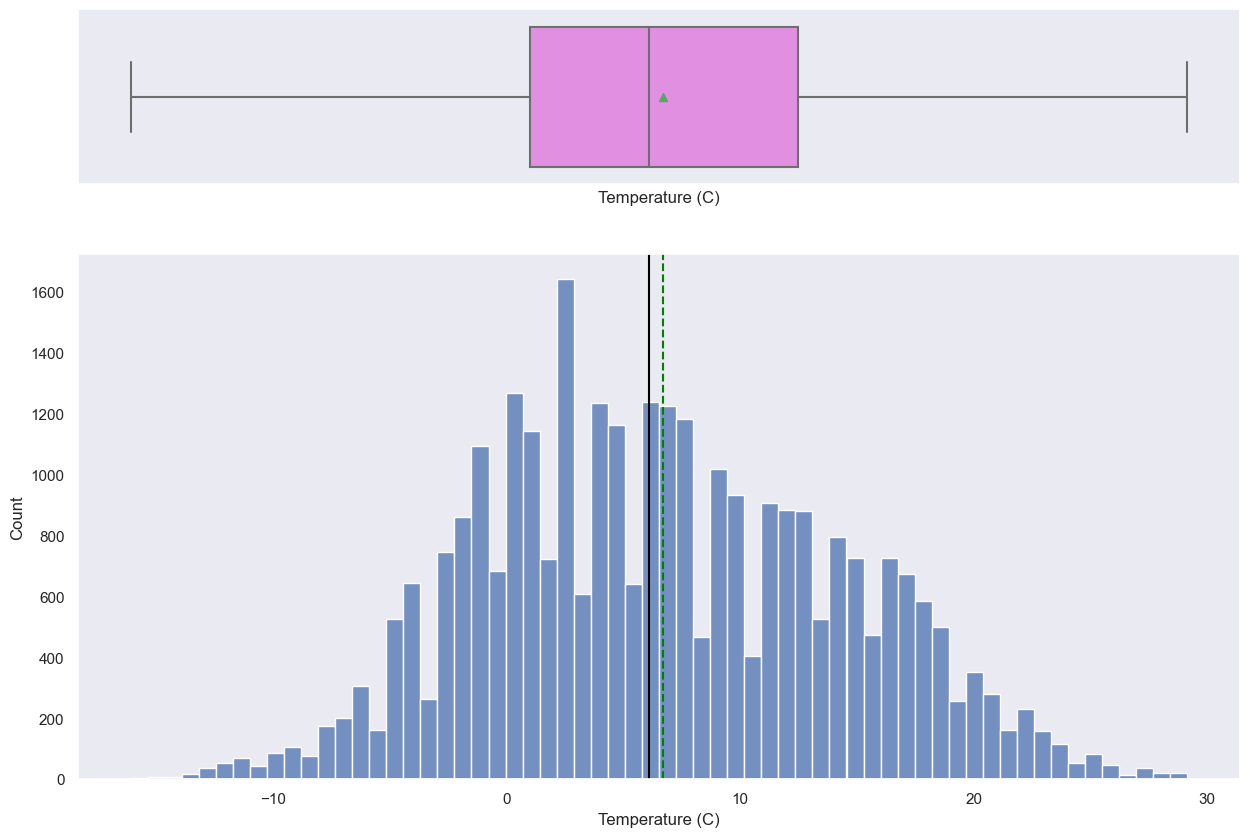

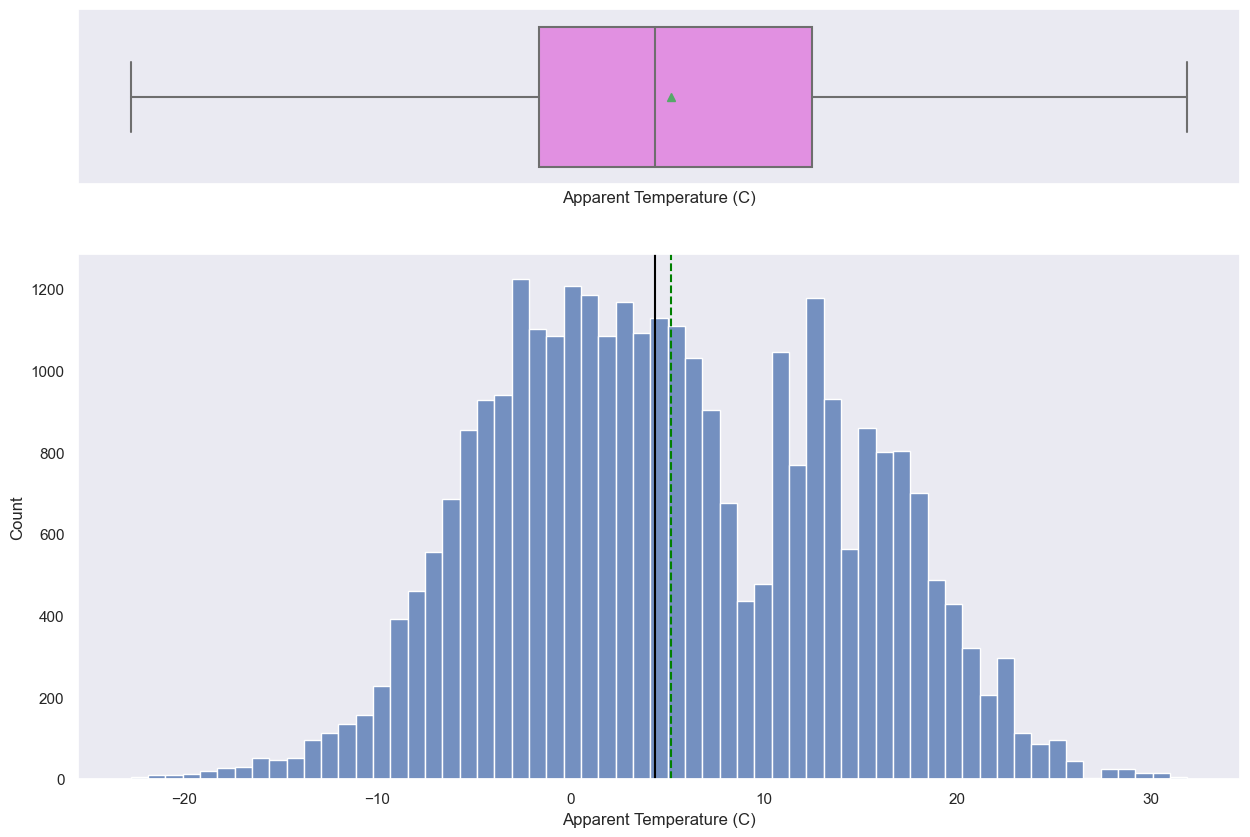

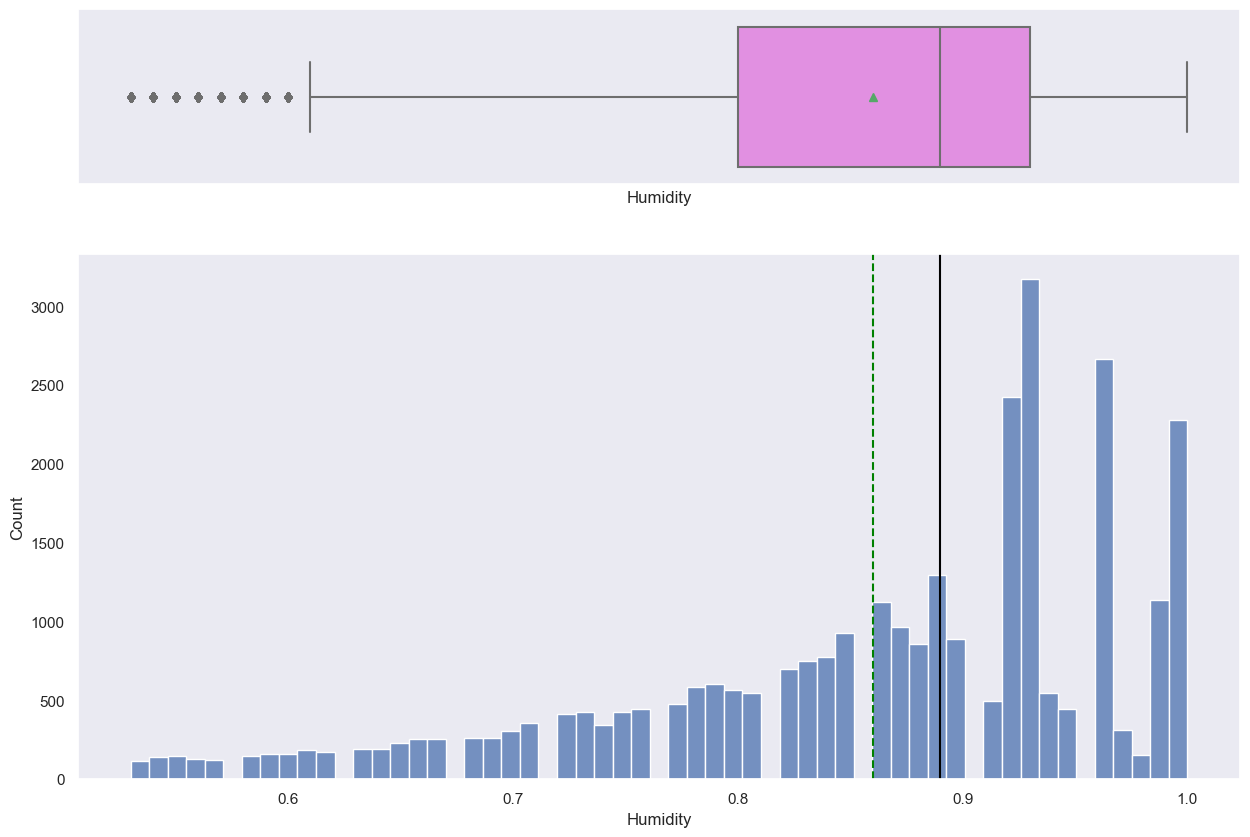

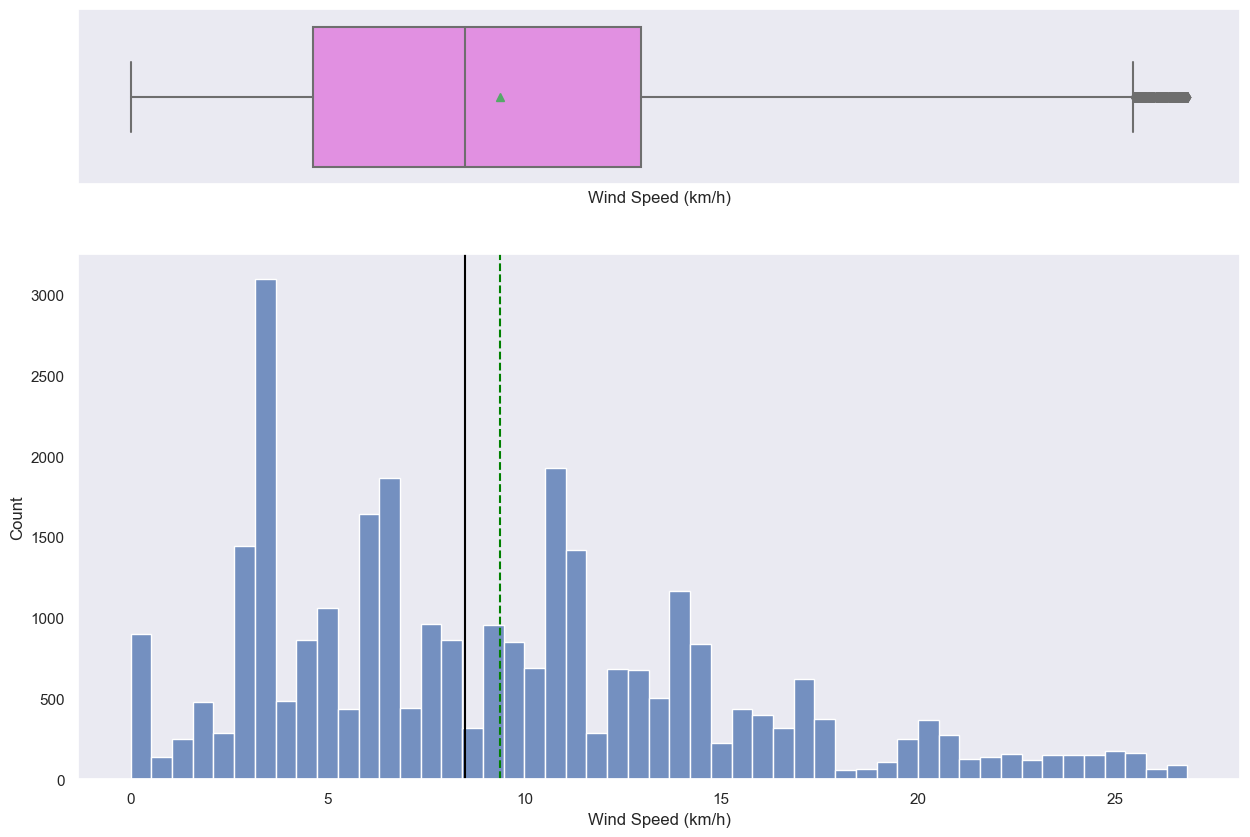

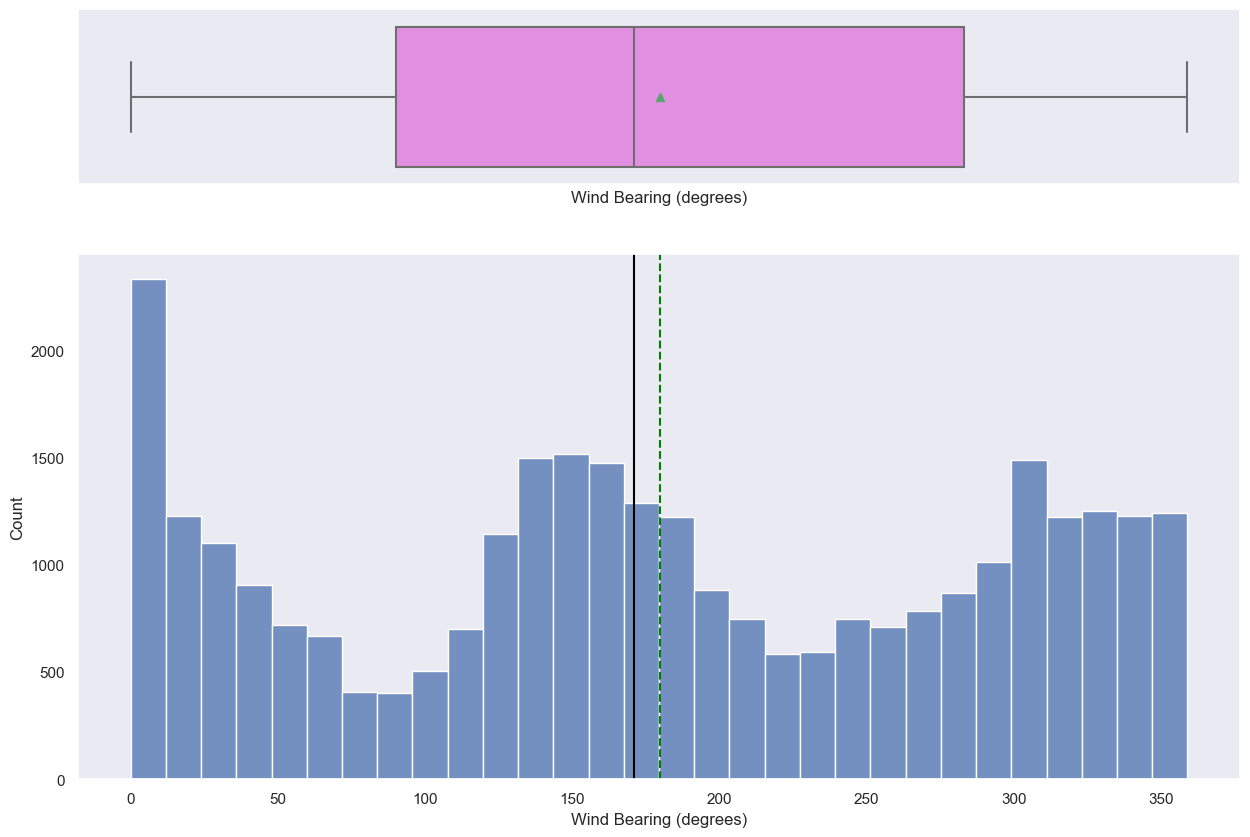

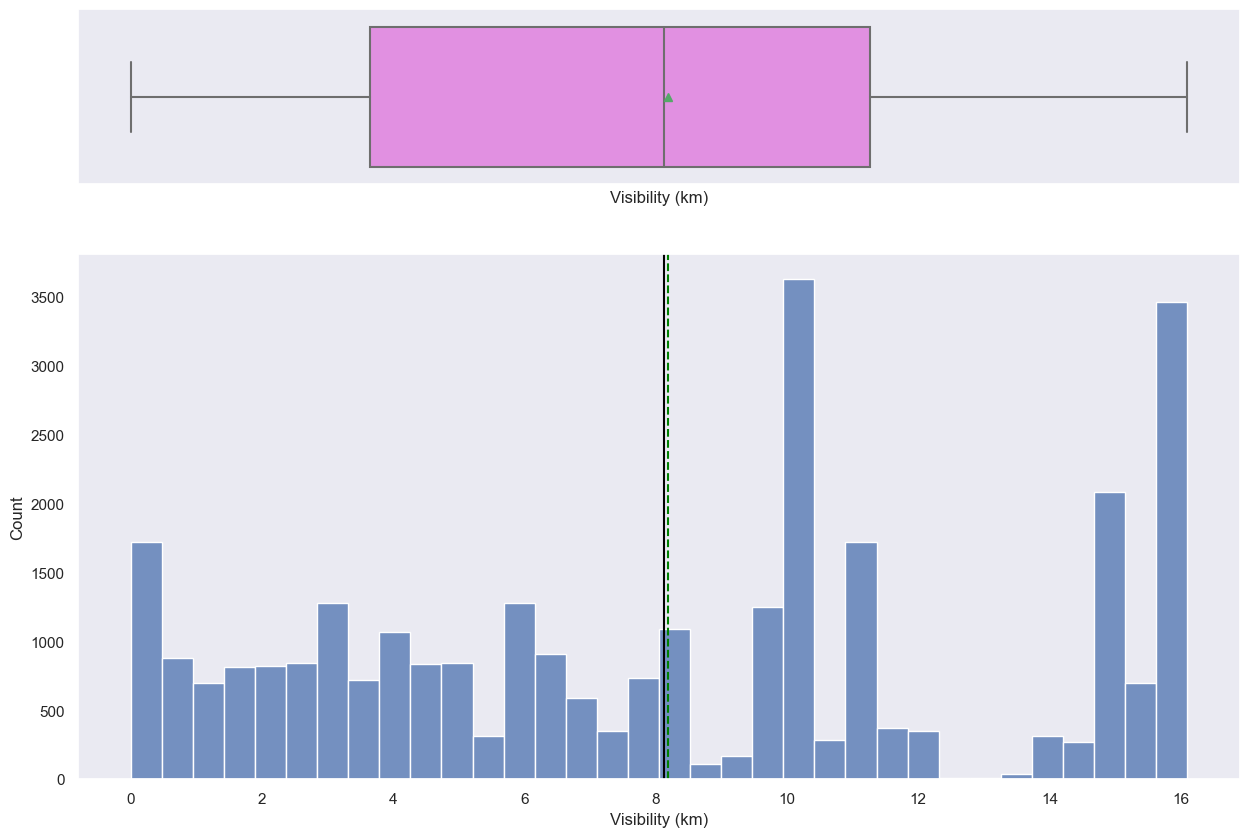

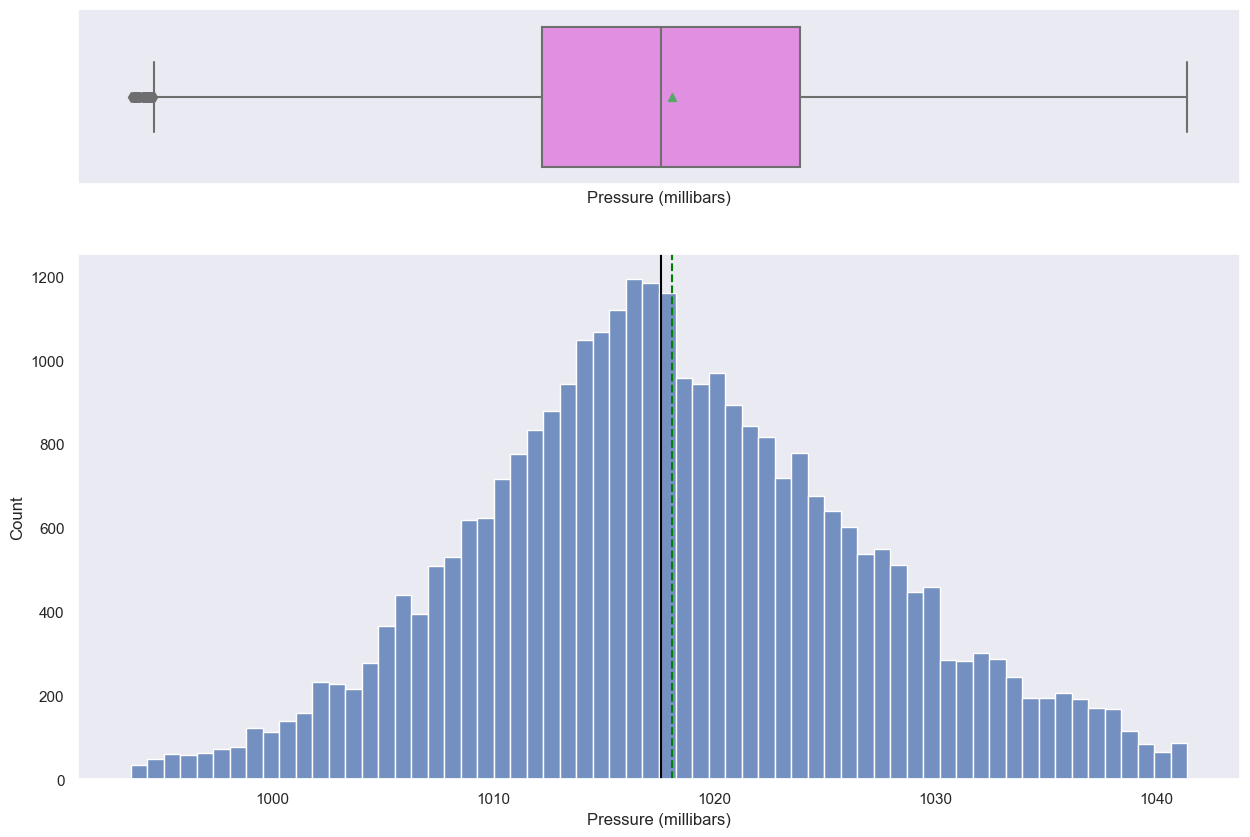

In [19]:
for i in numeric_columns:
    histogram_boxplot(data,i)

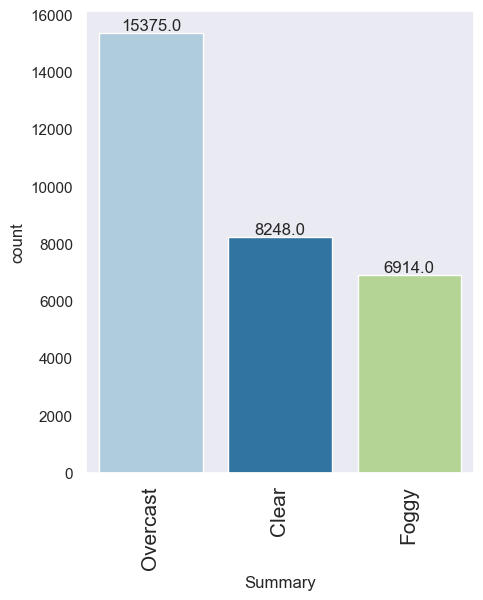

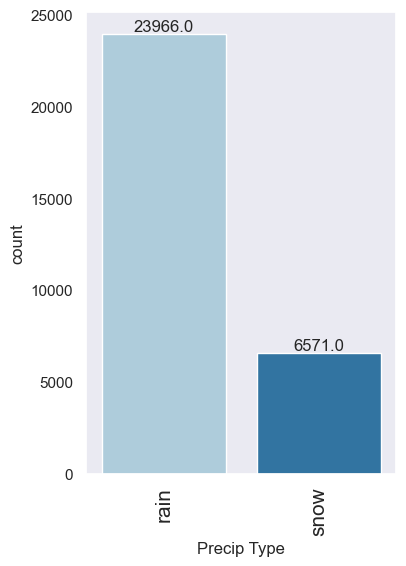

In [20]:
for i in categorical_columns:
    if i in ['Daily Summary','Time']:
        pass
    else:
        labeled_barplot(data, i)

Summary      Clear  Foggy  Overcast    All
Precip Type                               
All           8248   6914     15375  30537
rain          7052   4025     12889  23966
snow          1196   2889      2486   6571
------------------------------------------------------------------------------------------------------------------------


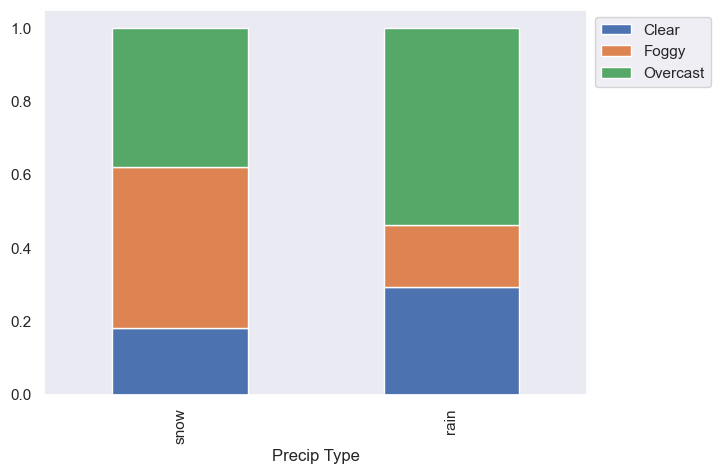

In [21]:
stacked_barplot(data,"Precip Type" , 'Summary')

In [22]:
counts = data["Summary"].value_counts()
total = counts.sum()
percentages = (counts / total) * 100
print(percentages)
print()
print("The classes are satifactory balanced")

Overcast    50.348757
Clear       27.009857
Foggy       22.641386
Name: Summary, dtype: float64

The classes are satifactory balanced


In [23]:
input_df = data.drop(columns="Summary", axis=1)
input_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Time,Year,Month,Day
46,rain,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,Mostly cloudy throughout the day.,22,2006,4,10
47,rain,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,Mostly cloudy throughout the day.,23,2006,4,10
48,rain,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,Foggy in the evening.,0,2006,4,11
49,rain,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,Foggy in the evening.,1,2006,4,11
50,rain,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,Foggy in the evening.,2,2006,4,11


In [24]:
encoder = LabelEncoder()
y = data["Summary"]
y = encoder.fit_transform(y)

class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
for class_label, class_number in class_mapping.items():
    print(f"Class '{class_label}' is labeled as {class_number}")

Class 'Clear' is labeled as 0
Class 'Foggy' is labeled as 1
Class 'Overcast' is labeled as 2


In [25]:
mapping = {'rain': 0, 'snow': 1}
input_df['Precip Type'] = input_df['Precip Type'].map(mapping)

In [26]:
input_df['Daily Summary Frequency'] = input_df['Daily Summary'].map(input_df['Daily Summary'].value_counts(normalize=True))
input_df.drop(columns=['Daily Summary'], axis=1, inplace=True)

input_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Time,Year,Month,Day,Daily Summary Frequency
46,0,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,22,2006,4,10,0.177457
47,0,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,23,2006,4,10,0.177457
48,0,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,0,2006,4,11,0.004617
49,0,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,1,2006,4,11,0.004617
50,0,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,2,2006,4,11,0.004617


In [27]:
input_df.drop(['Daily Summary Frequency'], axis=1, inplace=True)

In [28]:
input_df.drop(['Temperature (C)'], axis=1, inplace=True)

In [29]:
#training and testing 
X = input_df.values
X

array([[0.000e+00, 1.442e+01, 5.800e-01, ..., 2.006e+03, 4.000e+00,
        1.000e+01],
       [0.000e+00, 1.426e+01, 5.900e-01, ..., 2.006e+03, 4.000e+00,
        1.000e+01],
       [0.000e+00, 1.377e+01, 6.000e-01, ..., 2.006e+03, 4.000e+00,
        1.100e+01],
       ...,
       [0.000e+00, 1.502e+01, 9.000e-01, ..., 2.016e+03, 9.000e+00,
        9.000e+00],
       [0.000e+00, 1.387e+01, 9.300e-01, ..., 2.016e+03, 9.000e+00,
        9.000e+00],
       [0.000e+00, 1.607e+01, 8.800e-01, ..., 2.016e+03, 9.000e+00,
        9.000e+00]])

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [32]:
#RANDOM FOREST
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5]}
model_rf = RandomForestClassifier()
models_rf = GridSearchCV(estimator=model_rf, param_grid=parameters, cv=4)
models_rf.fit(x_train, y_train)
best_parameters = models_rf.best_params_
print("Best Hyperparameters:", best_parameters)
print()

best_model_rf = models_rf.best_estimator_
y_pred_rf = best_model_rf.predict(x_train)

y_pred_rf_new = best_model_rf.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_rf, y_test, y_pred_rf_new)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Random Forest

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94



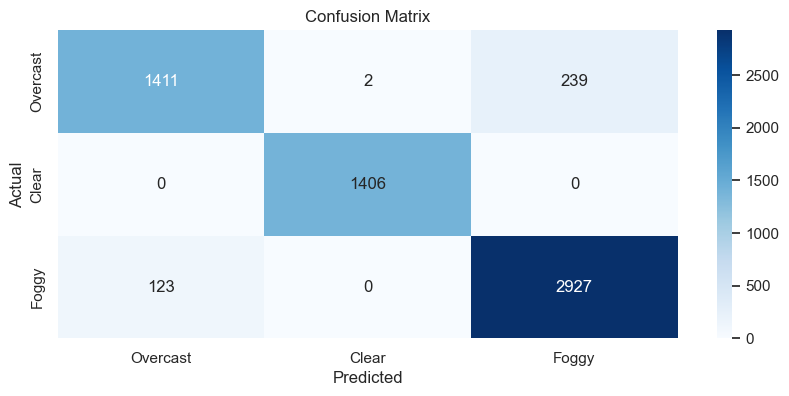

In [33]:
print("Testing Performance")
accuracy_rf, precision_rf, recall_rf, f1_rf = calculate_classification_metrics(y_test, y_pred_rf_new, "Random Forest")

In [34]:
#KNN
parameters = {'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree','kd_tree','brute'],
            'p': [1,2]}
model_knn = KNeighborsClassifier(n_neighbors=5)
models_knn = GridSearchCV(estimator=model_knn, param_grid=parameters, cv=4)
models_knn.fit(x_train, y_train)
best_parameters = models_knn.best_params_
print("Best Hyperparameters:", best_parameters)
print()
best_model_knn = models_knn.best_estimator_
y_pred_knn = best_model_knn.predict(x_train)
y_pred_knn_new = best_model_knn.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_knn, y_test, y_pred_knn_new)

Best Hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  KNN

Accuracy: 0.905
Precision: 0.905
Recall: 0.905
F1 Score: 0.905



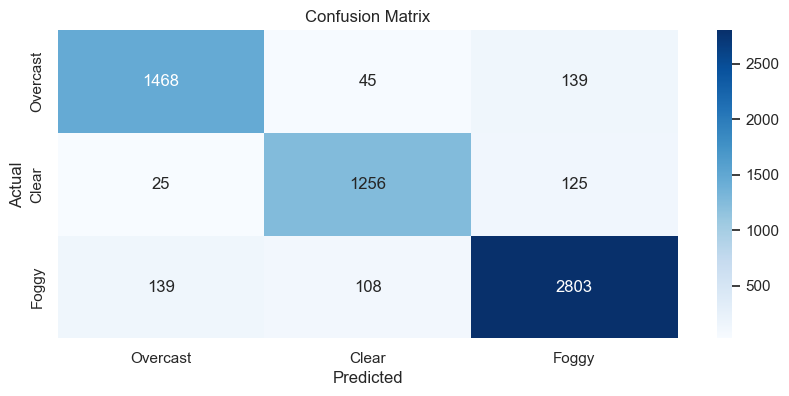

In [35]:
print("Testing Performance")
accuracy_knn, precision_knn, recall_knn, f1_knn = calculate_classification_metrics(y_test, y_pred_knn_new, "KNN")

In [36]:
print("Testing Performances for Machine Learning Algorithms")
result = pd.DataFrame({"Algorithms":["Random Forest","KNN"],
                       "Accuracy":[accuracy_rf, accuracy_knn],
                       "Precision":[precision_rf, precision_knn],
                       "Recall":[recall_rf, recall_knn],
                       "F1 Score":[f1_rf, f1_knn]}).set_index('Algorithms')
result

Testing Performances for Machine Learning Algorithms


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
Random Forest,0.940,0.940,0.940,0.940
KNN,0.905,0.905,0.905,0.905


In [37]:
num_classes = 3
epochs = 150
input_dimension = x_train.shape[1]
batch_size = 64
learning_rate = 0.001

In [38]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

In [39]:
x_train_reshaped = np.expand_dims(x_train, axis=2)
x_test_reshaped = np.expand_dims(x_test, axis=2)

In [40]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_dim=input_dimension)) 
model.add(tf.keras.layers.Dense(64, activation='relu')) 
model.add(tf.keras.layers.Dense(128, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

stop_callback = myCallback()

history = model.fit(x_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_encoded), callbacks=[stop_callback])



Epoch 1/150
382/382 [==============================] - 2s 2ms/step - loss: 0.4979 - accuracy: 0.7747 - val_loss: 0.3865 - val_accuracy: 0.8297
Epoch 2/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3799 - accuracy: 0.8317 - val_loss: 0.3591 - val_accuracy: 0.8436
Epoch 3/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3514 - accuracy: 0.8439 - val_loss: 0.3368 - val_accuracy: 0.8536
Epoch 4/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3298 - accuracy: 0.8547 - val_loss: 0.3355 - val_accuracy: 0.8571
Epoch 5/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3161 - accuracy: 0.8609 - val_loss: 0.3235 - val_accuracy: 0.8572
Epoch 6/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3021 - accuracy: 0.8708 - val_loss: 0.2970 - val_accuracy: 0.8731
Epoch 7/150
382/382 [==============================] - 1s 2ms/step - loss: 0.2951 - accuracy: 0.8727 - val_loss: 0.2937 - val_accuracy: 0.8728

Epoch 58/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1432 - accuracy: 0.9417 - val_loss: 0.2457 - val_accuracy: 0.9083
Epoch 59/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1404 - accuracy: 0.9436 - val_loss: 0.2637 - val_accuracy: 0.9000
Epoch 60/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1351 - accuracy: 0.9452 - val_loss: 0.2454 - val_accuracy: 0.9118
Epoch 61/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1365 - accuracy: 0.9438 - val_loss: 0.2505 - val_accuracy: 0.9083
Epoch 62/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1362 - accuracy: 0.9444 - val_loss: 0.2430 - val_accuracy: 0.9113
Epoch 63/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1346 - accuracy: 0.9455 - val_loss: 0.2714 - val_accuracy: 0.9018
Epoch 64/150
382/382 [==============================] - 2s 4ms/step - loss: 0.1299 - accuracy: 0.9479 - val_loss: 0.2645 - val_accuracy:

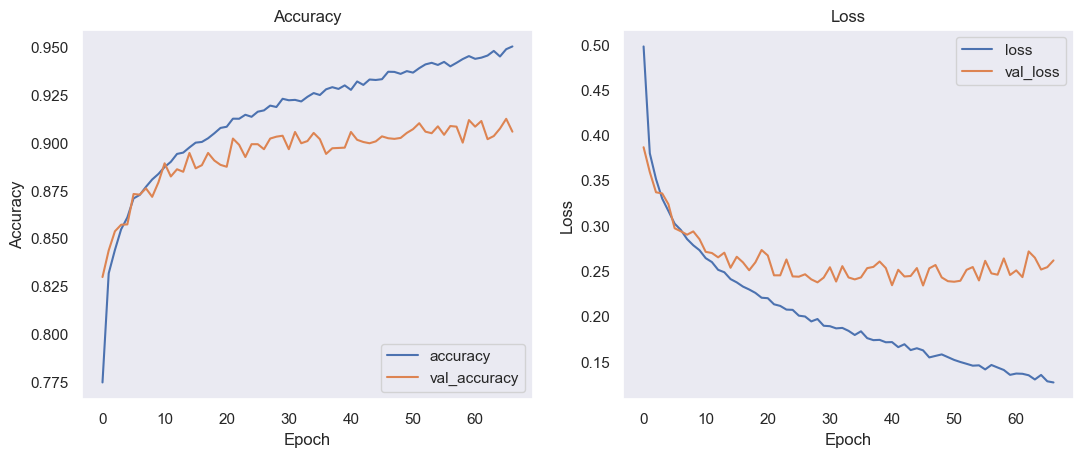

In [41]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          
plt.plot(history.history['val_loss'], label='val_loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [42]:
test_loss_0, test_accuracy_0 = model.evaluate(x_test, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_0)
print('Test Accuracy:', test_accuracy_0)

model.save('FFNN.h5')

Test Loss: 0.2614947557449341
Test Accuracy: 0.9056974649429321


In [43]:
#RNN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(input_dimension, 1)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

stop_callback = myCallback()

history = model.fit(x_train_reshaped, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test_reshaped, y_test_encoded), callbacks=[stop_callback])

Epoch 1/150
382/382 [==============================] - 4s 5ms/step - loss: 0.6076 - accuracy: 0.7148 - val_loss: 0.4279 - val_accuracy: 0.8034
Epoch 2/150
382/382 [==============================] - 1s 4ms/step - loss: 0.4160 - accuracy: 0.8112 - val_loss: 0.4210 - val_accuracy: 0.8057
Epoch 3/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3906 - accuracy: 0.8219 - val_loss: 0.3789 - val_accuracy: 0.8297
Epoch 4/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3766 - accuracy: 0.8317 - val_loss: 0.3777 - val_accuracy: 0.8363
Epoch 5/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3663 - accuracy: 0.8357 - val_loss: 0.3667 - val_accuracy: 0.8414
Epoch 6/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3573 - accuracy: 0.8417 - val_loss: 0.3709 - val_accuracy: 0.8348
Epoch 7/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3462 - accuracy: 0.8462 - val_loss: 0.3584 - val_accuracy: 0.8418

Epoch 58/150
382/382 [==============================] - 1s 3ms/step - loss: 0.2207 - accuracy: 0.9055 - val_loss: 0.2785 - val_accuracy: 0.8872
Epoch 59/150
382/382 [==============================] - 1s 4ms/step - loss: 0.2204 - accuracy: 0.9072 - val_loss: 0.2723 - val_accuracy: 0.8897
Epoch 60/150
382/382 [==============================] - 1s 4ms/step - loss: 0.2184 - accuracy: 0.9080 - val_loss: 0.2658 - val_accuracy: 0.8947
Epoch 61/150
382/382 [==============================] - 1s 3ms/step - loss: 0.2134 - accuracy: 0.9094 - val_loss: 0.2917 - val_accuracy: 0.8857
Epoch 62/150
382/382 [==============================] - 1s 4ms/step - loss: 0.2157 - accuracy: 0.9087 - val_loss: 0.3045 - val_accuracy: 0.8782
Epoch 63/150
382/382 [==============================] - 1s 3ms/step - loss: 0.2121 - accuracy: 0.9127 - val_loss: 0.2862 - val_accuracy: 0.8867
Epoch 64/150
382/382 [==============================] - 1s 4ms/step - loss: 0.2169 - accuracy: 0.9104 - val_loss: 0.2872 - val_accuracy:

Epoch 115/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1658 - accuracy: 0.9322 - val_loss: 0.2906 - val_accuracy: 0.8916
Epoch 116/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1669 - accuracy: 0.9314 - val_loss: 0.2902 - val_accuracy: 0.8939
Epoch 117/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1711 - accuracy: 0.9295 - val_loss: 0.2987 - val_accuracy: 0.8934
Epoch 118/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.9326 - val_loss: 0.2619 - val_accuracy: 0.9060
Epoch 119/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.9327 - val_loss: 0.2915 - val_accuracy: 0.8941
Epoch 120/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.9321 - val_loss: 0.3075 - val_accuracy: 0.8934
Epoch 121/150
382/382 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.9322 - val_loss: 0.2913 - val_ac

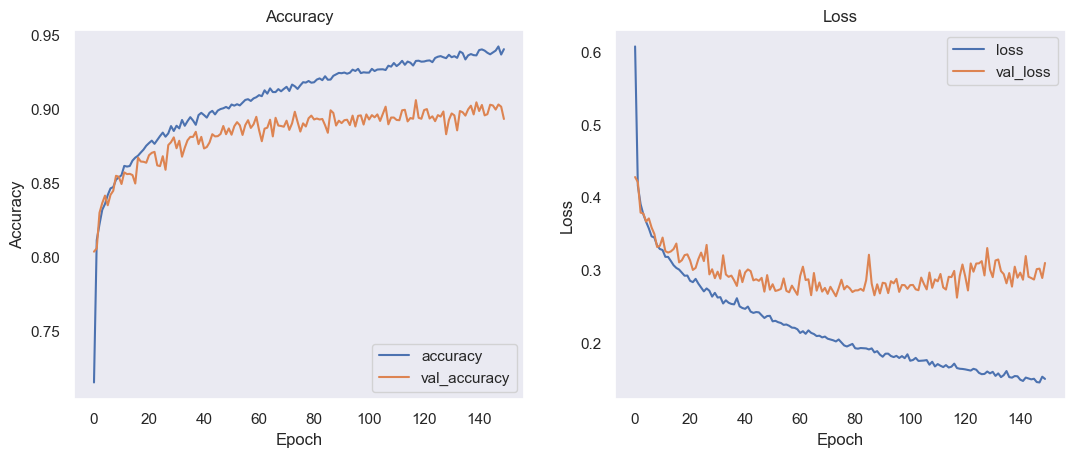

In [44]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          
plt.plot(history.history['val_loss'], label='val_loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [45]:
test_loss_3, test_accuracy_3 = model.evaluate(x_test_reshaped, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_3)
print('Test Accuracy:', test_accuracy_3)

Test Loss: 0.3096463978290558
Test Accuracy: 0.8932547569274902
